In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("sweetspot_optimized.csv")

# Define spatial coordinate columns
spatial_cols = ["Bottomhole X", "Bottomhole Y"]

# Check if columns exist
if not all(col in df.columns for col in spatial_cols):
    raise ValueError(f"Missing spatial columns! Found: {df.columns}")

# Extract spatial coordinates
coords = df[spatial_cols].values  

# Define predictor variables (geological + operational)
features = ["POROS", "KX", "KY", "TD(MD)", "Pressure_Drawdown"]  # Adjusted for dataset
target = "Co [MSTB]"  # Target is cumulative oil production

# Define number of nearest neighbors
n_neighbors = 5  # Tune based on performance

In [3]:
# Find nearest neighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="ball_tree").fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Add nearest well features
for i in range(1, n_neighbors + 1):
    df[f"nn_{i}_POROS"] = df.iloc[indices[:, i - 1]]["POROS"].values
    df[f"nn_{i}_KX"] = df.iloc[indices[:, i - 1]]["KX"].values
    df[f"nn_{i}_KY"] = df.iloc[indices[:, i - 1]]["KY"].values
    df[f"nn_{i}_TD"] = df.iloc[indices[:, i - 1]]["TD(MD)"].values
    df[f"nn_{i}_Pressure"] = df.iloc[indices[:, i - 1]]["Pressure_Drawdown"].values
    df[f"nn_{i}_distance"] = distances[:, i - 1]  # Distance to each neighbor

# Prepare final feature set
spatial_features = [col for col in df.columns if col.startswith("nn_")]
final_features = features + spatial_features

X = df[final_features]
y = df[target]


In [4]:
# Train Random Forest Model with RFSI Features
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

# Perform Nested Cross-Validation (Leave-Location-Out)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=kf, scoring="r2")

# Train on full dataset
rf.fit(X, y)

# Make Predictions
y_pred = rf.predict(X)

In [5]:
# Model Performance
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"Cross-Validation R²: {cv_scores.mean():.3f}")
print(f"Train MAE: {mae:.3f}")
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R²: {r2:.3f}")


Cross-Validation R²: 0.751
Train MAE: 4.219
Train RMSE: 6.073
Train R²: 0.979


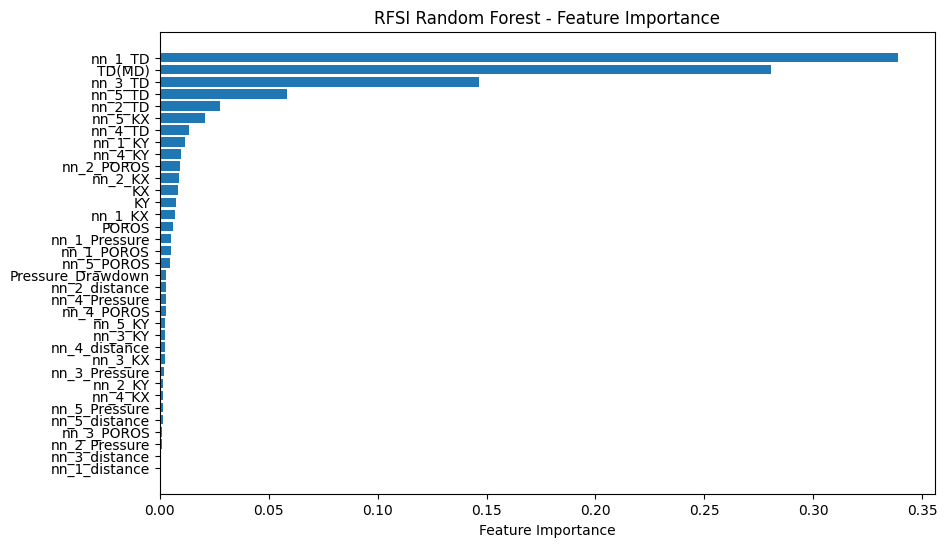

In [6]:
# Feature Importance Analysis
importances = rf.feature_importances_
feature_names = X.columns

# Sort by importance
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_indices], align="center")
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_indices])
plt.xlabel("Feature Importance")
plt.title("RFSI Random Forest - Feature Importance")
plt.gca().invert_yaxis()
plt.show()